In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2 
import time

### MP Holistics for Detection and Recognition

In [2]:
import mediapipe as mp
mp_holistic = mp.solutions.holistic     ### holistic used for whole detection of the body like face, hands etc
mp_drawing = mp.solutions.drawing_utils     ## used for drawing landmarks

In [3]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Here, the transformed RGB image is passed to the MediaPipe model for processing.
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [4]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

In [5]:
def draw_styled_landmarks(image, results):

    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [6]:
cap = cv2.VideoCapture(0)
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:  # setting holistic model
    while cap.isOpened():       ## eading frame
        ret, Frame = cap.read()

        image, results = mediapipe_detection(Frame , holistic)   # Making prediction using mediapipe
        print(results)

        draw_styled_landmarks(image, results)      # for landmarks
        
        cv2.imshow("Camera", image)
        if cv2.waitKey(10) & 0xFF == ord('l'):
            break

    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

In [7]:
len(results.face_landmarks.landmark)

468

In [8]:
draw_landmarks(Frame, results)

(-0.5, 639.5, 479.5, -0.5)

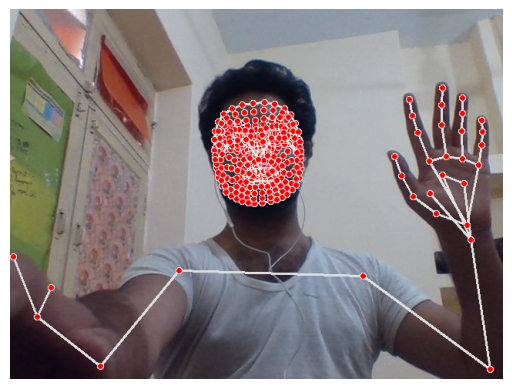

In [9]:
plt.imshow(cv2.cvtColor(Frame, cv2.COLOR_BGR2RGB))
plt.axis('off')

### Extracting Keypoints from landamarks

In [10]:
print(len(results.pose_landmarks.landmark))
results.face_landmarks.landmark[0]

33


x: 0.5067917704582214
y: 0.425095796585083
z: -0.029300615191459656

In [11]:
pose = []
for result in results.pose_landmarks.landmark:
    test = np.array([result.x, result.y, result.z, result.visibility])
    pose.append(test)

In [12]:
len(pose)

33

In [13]:
### just flatten the result so give that to a lstm model
pose = np.array([[result.x, result.y, result.z, result.visibility] for result in results.pose_landmarks.landmark]).flatten()

In [14]:
print(pose.shape)           ### 132 because of four (x,y,z,visbility * 33)  = 132
len(pose)

(132,)


132

In [15]:
len(results.left_hand_landmarks.landmark)

21

In [16]:
### now just for lefthand landmarks
lh = np.array([[result.x, result.y, result.z] for result in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)

In [17]:
rh = np.array([[result.x, result.y, result.z] for result in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)

In [18]:
len(results.face_landmarks.landmark)*3

1404

In [19]:
face = np.array([[result.x, result.y, result.z] for result in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)

In [20]:
### just flatten the result so give that to a lstm model
pose = np.array([[result.x, result.y, result.z, result.visibility] for result in results.pose_landmarks.landmark]).flatten()
### these are face landmarks and the face landmarks in 3d are 1404/3
face = np.array([[result.x, result.y, result.z] for result in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)
### now just for lefthand landmarks
lh = np.array([[result.x, result.y, result.z] for result in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
### now landmarks for right hand
rh = np.array([[result.x, result.y, result.z] for result in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)

###  we will just get all teh landamarks except from rh hand landamarks because that hand is nit in the last frame that we captured 

In [21]:
def extract_keypoints(results):
    ### just flatten the result so give that to a lstm model
    pose = np.array([[result.x, result.y, result.z, result.visibility] for result in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    ### these are face landmarks and the face landmarks in 3d are 1404/3
    face = np.array([[result.x, result.y, result.z] for result in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)
    ### now just for lefthand landmarks
    lh = np.array([[result.x, result.y, result.z] for result in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    ### now landmarks for right hand
    rh = np.array([[result.x, result.y, result.z] for result in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    
    return np.concatenate([pose, face, lh,rh])

In [24]:
extract_keypoints(results).shape

(1662,)

In [25]:
result_test = extract_keypoints(results)
np.save('0', result_test)

In [26]:
np.load('0.npy')

array([ 0.50386322,  0.40667614, -0.71337152, ...,  0.        ,
        0.        ,  0.        ])

In [27]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('MP_Data') 

# Actions that we try to detect
actions = np.array(['hello', 'thanks', 'iloveyou'])

# Thirty videos of length 30 frames number of sequences
no_sequences = 30

# Videos are going to be 30 frames in length
sequence_length = 30

In [28]:
### this will just create folder for different actiona and then each frame in each folder like hello->1,2,3,....
for action in actions: 
    for sequence in range(no_sequences):
        try: 
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

In [29]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    # NEW LOOP
    # Loop through actions
    for action in actions:
        # Loop through sequences aka videos
        for sequence in range(no_sequences):
            # Loop through video length aka sequence length
            for frame_num in range(sequence_length):

                # Read feed
                ret, frame = cap.read()

                # Make detections
                image, results = mediapipe_detection(frame, holistic)
#                 print(results)

                # Draw landmarks
                draw_styled_landmarks(image, results)
                
                # NEW Apply wait logic
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(2000)
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                
                # NEW Export keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                    
    cap.release()
    cv2.destroyAllWindows()

In [30]:
cap.release()
cv2.destroyAllWindows()

In [31]:
from sklearn.model_selection import train_test_split
import tensorflow
import keras
from tensorflow.keras.utils import to_categorical

In [32]:
label_map = {label: num for num, label in enumerate(actions)}
label_map

{'hello': 0, 'thanks': 1, 'iloveyou': 2}

In [33]:
sequences, labels = [], []
for action in actions:
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            result = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(result)
        sequences.append(window)
        labels.append(label_map[action])

In [34]:
np.array(sequences).shape

(90, 30, 1662)

In [35]:
X = np.array(sequences)     ### this is just preprocessing 
y = to_categorical(labels).astype(int)

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

### lstm model

In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [54]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(256, return_sequences=False, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [55]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [52]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 30, 64)            442112    
                                                                 
 lstm_4 (LSTM)               (None, 30, 128)           98816     
                                                                 
 lstm_5 (LSTM)               (None, 64)                49408     
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 3)                 99        
                                                                 
Total params: 596675 (2.28 MB)
Trainable params: 59667

In [ ]:
model.fit(X_train, y_train, epochs=2000, validation_data=[X_test, y_test])

In [42]:
res = model.predict(X_test)

1/1 [==============================] - 0s 473ms/step


In [43]:
actions[np.argmax(res[4])]

'iloveyou'

In [44]:
actions[np.argmax(y_test[4])]

'hello'

In [45]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [46]:
yhat = model.predict(X_test)

1/1 [==============================] - 0s 42ms/step


In [47]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [48]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[2, 0],
        [3, 0]],

       [[4, 0],
        [1, 0]],

       [[0, 4],
        [0, 1]]], dtype=int64)

In [49]:
accuracy_score(ytrue, yhat)

0.2